### 1. Setup and Imports

In [3]:
# Import all necessary libraries for data handling, modeling, evaluation, and visualization.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import os

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Tuning and Evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Set plot style
sns.set_style("whitegrid")

# Create directories if they don't exist
os.makedirs('../models', exist_ok=True)
os.makedirs('../outputs', exist_ok=True)

### 2. Data Preparation

In [4]:
# Load the dataset, identify feature types, and create a preprocessing pipeline.

# Load data
df = pd.read_csv('../data/heart_disease_uci.csv')

In [10]:
print("Dataset Head:")
df.head()

Dataset Head:


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [11]:
print("\nDataset Info:")
df.info()



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


#### --- DATA CLEANING AND FEATURE ENGINEERING ---

In [12]:
# Create the binary target variable: 0 for no disease, 1 for disease
# The 'num' column indicates the presence of heart disease (values > 0)
df['target'] = (df['num'] > 0).astype(int)

In [13]:
# Drop original 'num' column and other irrelevant columns like 'id' and 'dataset'
df = df.drop(['id', 'dataset', 'num'], axis=1)

In [14]:
print("Cleaned Dataset Head:")
df.head()

Cleaned Dataset Head:


,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [15]:

print("\nDataset Info after cleaning:")
df.info()


Dataset Info after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   cp        920 non-null    object 
 3   trestbps  861 non-null    float64
 4   chol      890 non-null    float64
 5   fbs       830 non-null    object 
 6   restecg   918 non-null    object 
 7   thalch    865 non-null    float64
 8   exang     865 non-null    object 
 9   oldpeak   858 non-null    float64
 10  slope     611 non-null    object 
 11  ca        309 non-null    float64
 12  thal      434 non-null    object 
 13  target    920 non-null    int32  
dtypes: float64(5), int32(1), int64(1), object(7)
memory usage: 97.2+ KB


In [16]:
# Define target and features
X = df.drop('target', axis=1)
y = df['target']

In [17]:
# Manually define categorical and numerical features based on dataset knowledge
# This is more robust than relying on dtypes.
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
numerical_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']


In [18]:
print(f"\nCategorical Features: {categorical_features}")
print(f"Numerical Features: {numerical_features}")


Categorical Features: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
Numerical Features: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']


#### --- PREPROCESSING PIPELINES ---

In [19]:
# For numerical features, we impute missing values with the median and then scale.
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [20]:
# For categorical features, we impute missing values with the most frequent value and then one-hot encode.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [21]:
# Create a preprocessor object using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (736, 13)
Testing set shape: (184, 13)


### 3. Model Candidates and Hyperparameter Grids

In [24]:
# Define the models we want to evaluate and the hyperparameter grids for tuning.

models = {
    "SVM": SVC(probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
}

In [25]:
# Define parameter grids for GridSearchCV
# Note: These grids are small for quick execution. For a real project, expand them.
param_grids = {
    "SVM": {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['rbf'],
        'model__gamma': ['scale']
    },
    "RandomForest": {
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, 20],
        'model__min_samples_split': [2, 5]
    },
    "XGBoost": {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [3, 5]
    }
}

### 4. Cross-Validation and Hyperparameter Tuning

In [26]:
# Iterate through each model, create a full pipeline with the preprocessor,
# and use GridSearchCV to find the best hyperparameters.

best_estimators = {}
tuning_results = []

for name, model in models.items():
    print(f"--- Tuning {name} ---")
    
    # Create the full pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(
        pipeline,
        param_grids[name],
        cv=5,
        scoring='roc_auc', # Using AUC as the primary metric
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)
    
    # Store the best estimator
    best_estimators[name] = grid_search.best_estimator_
    
    # Store tuning results
    tuning_results.append({
        "Model": name,
        "Best Score (AUC)": grid_search.best_score_,
        "Best Params": grid_search.best_params_
    })
    
    print(f"Best Score (AUC) for {name}: {grid_search.best_score_:.4f}")
    print(f"Best Params for {name}: {grid_search.best_params_}\n")


--- Tuning SVM ---
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Score (AUC) for SVM: 0.8941
Best Params for SVM: {'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}

--- Tuning RandomForest ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Score (AUC) for RandomForest: 0.8787
Best Params for RandomForest: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 200}

--- Tuning XGBoost ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits


e:\Private\AI-PROJECTS-PORTFOLIO-DOCS-ASSETS\ALL-PROJECTS-PACKAGES\ai-core-foundation\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:59:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Score (AUC) for XGBoost: 0.8811
Best Params for XGBoost: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}



In [27]:
# Save the tuning results to a CSV
tuning_df = pd.DataFrame(tuning_results)
tuning_df.to_csv('../outputs/tuning_results.csv', index=False)
print("\nTuning results saved to '../outputs/tuning_results.csv'")
print(tuning_df)


Tuning results saved to '../outputs/tuning_results.csv'
          Model  Best Score (AUC)  \
0           SVM          0.894088   
1  RandomForest          0.878742   
2       XGBoost          0.881119   

                                         Best Params  
0  {'model__C': 1, 'model__gamma': 'scale', 'mode...  
1  {'model__max_depth': 10, 'model__min_samples_s...  
2  {'model__learning_rate': 0.05, 'model__max_dep...  


### 5. Performance Evaluation on Test Set

In [28]:
# Evaluate the best-tuned models on the unseen test data.

results = []
for name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "F1": f1,
        "Recall": recall,
        "AUC": auc
    })


In [29]:
# Convert results to a DataFrame for easy viewing and saving
results_df = pd.DataFrame(results)
print("\n--- Model Performance on Test Set ---")
print(results_df)


--- Model Performance on Test Set ---
          Model  Accuracy        F1    Recall       AUC
0           SVM  0.842391  0.866359  0.921569  0.916667
1  RandomForest  0.853261  0.870813  0.892157  0.922764
2       XGBoost  0.869565  0.886792  0.921569  0.922764


### 6. Identify and Save the Best Model

In [32]:
# Select the best model based on the highest AUC score on the test set.

best_model_name = results_df.sort_values(by='AUC', ascending=False).iloc[0]['Model']
best_model = best_estimators[best_model_name]

print(f"\n✅ Best Performing Model: {best_model_name}")

# Save the best model object
model_path = '../models/best_model.pkl'
joblib.dump(best_model, model_path)
print(f"Best model saved to '{model_path}'")

# Save the final metrics to a JSON file
metrics_path = '../models/model_metrics.json'
final_metrics_dict = results_df.to_dict(orient='records')
with open(metrics_path, 'w') as f:
    json.dump(final_metrics_dict, f, indent=4)
print(f"Model metrics saved to '{metrics_path}'")



✅ Best Performing Model: RandomForest
Best model saved to '../models/best_model.pkl'
Model metrics saved to '../models/model_metrics.json'


### 7. Visualize Results


Saved model comparison plot to 'outputs/model_comparison.png'


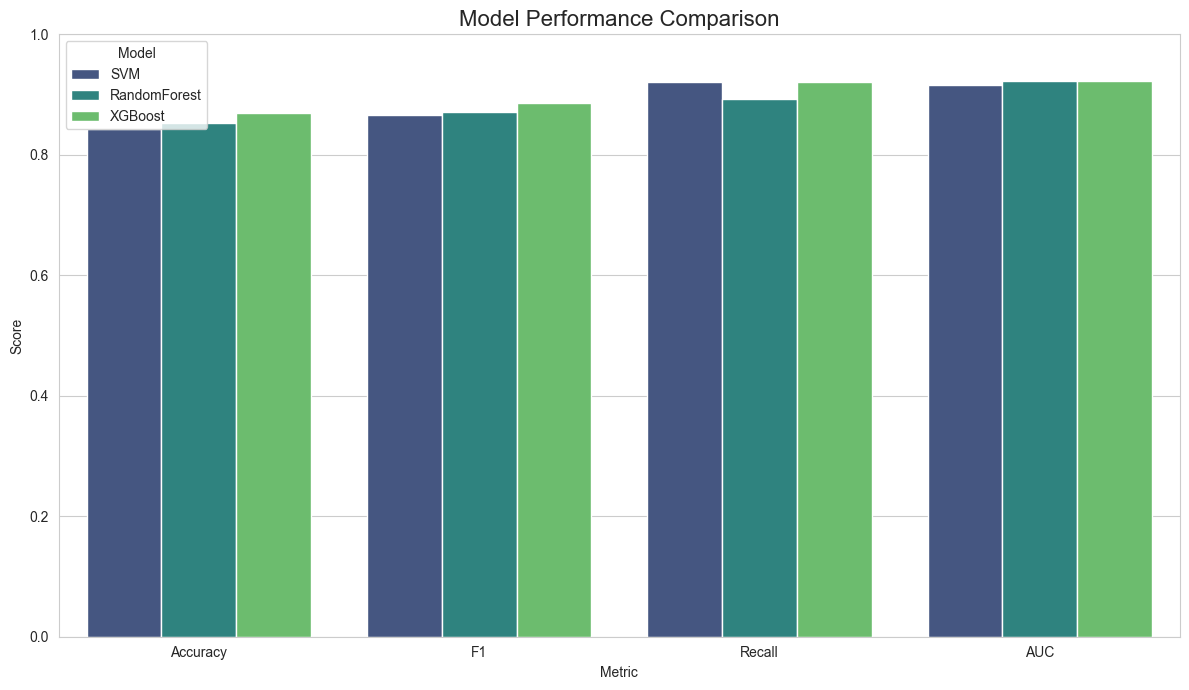

Saved confusion matrix plot to 'outputs/confusion_matrix_best.png'


<Figure size 800x600 with 0 Axes>

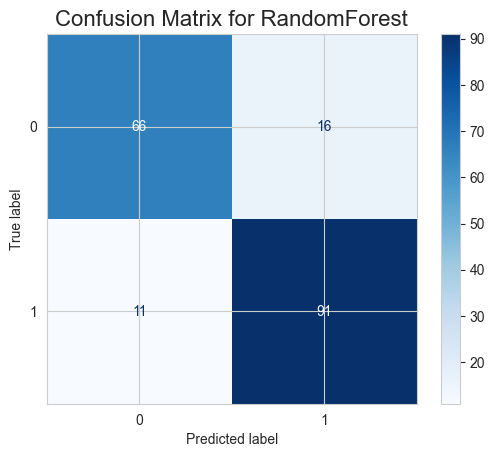


--- Project Complete ---


In [34]:
# Plot 1: Model Comparison
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 7))
sns.barplot(data=results_melted, x='Metric', y='Score', hue='Model', palette='viridis')
plt.title('Model Performance Comparison', fontsize=16)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.savefig('../outputs/model_comparison.png')
print("\nSaved model comparison plot to 'outputs/model_comparison.png'")
plt.show()

# Plot 2: Confusion Matrix for the Best Model
plt.figure(figsize=(8, 6))
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix for {best_model_name}', fontsize=16)
plt.savefig('../outputs/confusion_matrix_best.png')
print(f"Saved confusion matrix plot to 'outputs/confusion_matrix_best.png'")
plt.show()

print("\n--- Project Complete ---")
